이번 시간은 VAE 와 GAN 이죠? 바로 시작해보죠

# 0. Autoencoder


일단 VAE 를 보기 전에 AE 부터 볼겁니다. 설명했듯 Autoencoder 는 들어온 입력값을 복원하도록 학습하는 모델입니다.

이렇게 하는 이유가 있을 거 아니에요? 이는 네트워크가 스스로 알아서 유의미한 feature 를 찾아내도록 학습하기 위해서 입니다. 이렇게 autoencoder 로 한 번 학습하고 난 네트워크는 실제로 classification 문제를 풀도록 학습한 적이 없음에도 불구하고, 유의미한 feature 를 찾아내는 과정을 학습했기 때문에 꽤나 성능이 좋습니다! (이런걸 weight initialization 혹은 network initialization 이라고 합니다.)

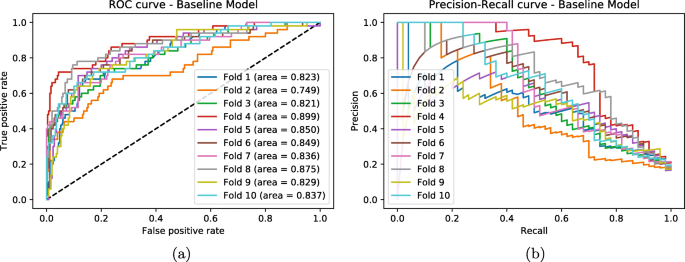



그래프는 ROC curve 라고 하는건데 뭘 의미하는지 잘 몰라도 괜찮습니다. 성능 평가하는 거고 높을수록 좋은데, autoencoder 쓴 빨간색이 다른것보다 높다는 것만 보면 됩니다. 그냥 좋다~ 

## 0.1. 데이터 불러오기

예제 데이터는 역시 MNIST 를 쓸게요 간단하고 불러오기 편하고.

In [25]:
import tensorflow as tf
import numpy as np
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=x_train.reshape((-1,784))
x_test=x_test.reshape((-1,784)) #  Flatten 하는거죠? 1 vector image 로 만듭니다

In [26]:
(np.min(x_train),np.max(x_train)) # 0부터 1로 매핑

(0.0, 1.0)

In [27]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, MaxPool2D, Flatten
from tensorflow.keras import Model

## 0.2. 모델-MLP 버전

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_30 (Dense)            (None, 64)                50240     
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 64)                1088      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 784)               

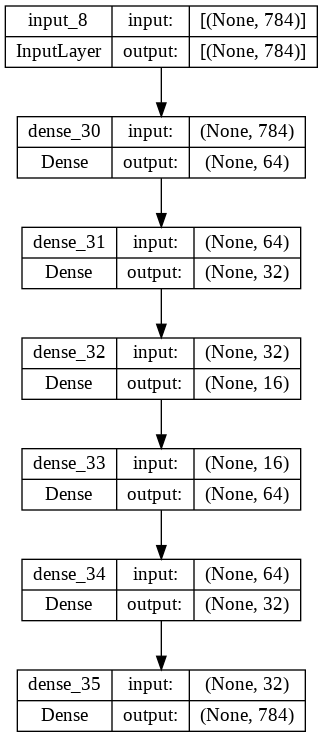

In [28]:
# MLP version autoencoder 

# encoding layer
inputs = tf.keras.Input(shape=(784,))
x_encoded = Dense(64, activation="relu")(inputs)
x_encoded = Dense(32, activation="relu")(x_encoded)

# feature vector
z = Dense(16, activation="relu")(x_encoded) 
# 기본적으로 아이디어 자체가 dimension 을 줄이는, 다차원의 데이터를 통해 차원을 
# 줄여 유의미한 feature 만 찾겠다는 것이기 때문에 이런식으로 128-64-32 로 줄어듭니다
# 왜 2의 배수를 쓰나요? 그래야 제 마음이 편해서.. 뭐 데이터 저장 효율성 뭐 그런게 있긴한데
# 그냥 그래야 마음이 편한게 첫째 이유

# decoding layer
x_decoded = Dense(64, activation="relu")(z)
x_decoded = Dense(32, activation="relu")(x_decoded) 
x_decoded = Dense(784, activation="sigmoid")(x_decoded) # MNIST 데이터가 0 에서 1 로 분포되어서 그렇습니다.

model = tf.keras.Model(inputs=inputs, outputs=x_decoded, name="mnist_model")
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ae.png', show_shapes=True)


## 0.3. 학습

In [29]:
# 자 그럼 학습 
num_epochs = 100
batch_size = 20
learning_rate = 1e-3
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer= adam, loss='mse') # 회귀 문제 (근데 그 대상이 오리지날 이미지인) 니까 mse 를 써야죠?

# 학습 시작
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/100
3000/3000 [==============================] - 14s 4ms/step - loss: 0.0368
Epoch 2/100
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0233
Epoch 3/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0208
Epoch 4/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0195
Epoch 5/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0183
Epoch 6/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0176
Epoch 7/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0171
Epoch 8/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0168
Epoch 9/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0165
Epoch 10/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0163
Epoch 11/100
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0160
Epoch 12/100
3000/3000 [==============================] - 12s 4ms

## 0.4. 결과 시각화

In [44]:
# 한 번 그림으로 볼까요?
from google.colab.patches import cv2_imshow

image_idx = 0


while image_idx < 10:

  image = x_train[image_idx,:].reshape(28,28)
  print("ORIGINAL:")
  cv2_imshow((image - np.min(image)) / np.max(image - np.min(image)) * 255)


  gen_image = model.predict(x_train[image_idx].reshape(1,-1))
  gen_image = gen_image.reshape((28,28))
  print("GENERATED:")
  cv2_imshow((gen_image - np.min(gen_image)) / np.max(gen_image - np.min(gen_image)) * 255)

  print('*'*50)
  image_idx+=1


ORIGINAL:


1/1 [==============================] - 0s 23ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 29ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 52ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 21ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 18ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 24ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 21ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 20ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 28ms/step
GENERATED:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 18ms/step
GENERATED:


**************************************************


나름 나쁘지 않죠?

## 0.5. 다른 모델?

여러분들이 CNN 을 쓰고 싶을 수 있을거에요. 왜냐하면 여러분이 다루는 이미지 데이터는 28 * 28 의 간단한 이미지가 아닐테니까요.

그럴땐 `tf.keras.layers.Conv2DTranspose`를 이용하면됩니다!

이건 모델을 직접 학습시키진 않을게요 궁금하면 해보십쇼

In [22]:
# 이미지 reshape
x_train = x_train.reshape((-1,28,28,1))

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         40        
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 8)        264       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       528       
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         65        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable p

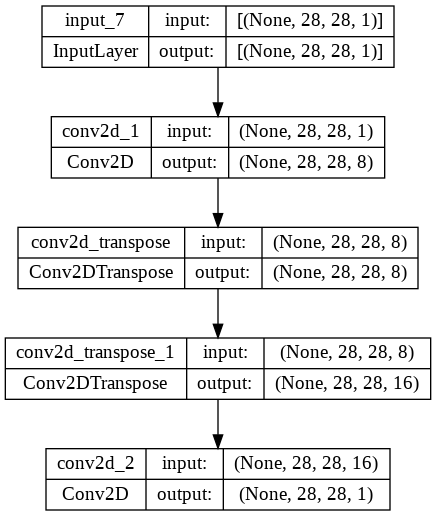

In [23]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
# CNN version autoencoder 

# encoding layer
inputs = tf.keras.Input(shape=(28,28,1))
x_encoded = Conv2D(16, (2,2), activation="relu", padding='same')(inputs)
x_encoded = Conv2D(8, (2,2), activation="relu", padding='same')(inputs)
# maxpool 을 써도 됩니다! 이건 28x28의 작은 이미지에다가
# 복원이 주 목적이라 maxpool 을 쓰면 정보손실이 너무 커서안쓸 뿐.

# feature vector
z = x_encoded
# 기본적으로 아이디어 자체가 dimension 을 줄이는, 다차원의 데이터를 통해 차원을 
# 줄여 유의미한 feature 만 찾겠다는 것이기 때문에 이런식으로 128-64-32 로 줄어듭니다
# 왜 2의 배수를 쓰나요? 그래야 제 마음이 편해서.. 뭐 데이터 저장 효율성 뭐 그런게 있긴한데
# 그냥 그래야 마음이 편한게 첫째 이유

# decoding layer
x_decoded = Conv2DTranspose(8, (2,2), activation="relu", padding='same')(z)
x_decoded = Conv2DTranspose(16, (2,2), activation="relu", padding='same')(x_decoded)
x_decoded = Conv2D(1,(2,2), activation="sigmoid", padding='same')(x_decoded)

model = tf.keras.Model(inputs=inputs, outputs=x_decoded, name="mnist_model")
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ae.png', show_shapes=True)


# 1. VAE

자 그럼 이제 VAE 를 볼건데요, 이거 위의 내용에서 한 가지 부분만 바뀌는거라 너무 쉽습니다. 우리가 gaussian 분포의 feature vector 로 강제 시키고 거기서 sampling 한다고 했죠?

이걸 대충 그렇게 되기를 바라면서 학습시켰던 MLP 와는 다르게, 직접적으로 gaussian 분포로 뽑을거에요. 즉 encoder network 의 아웃픗으로 나오는게 어떤 벡터라기보다는 정확히 말하면 gaussian 분포의 파라미터들 (평균과 표준편차: $\mu$ 와 $\sigma$) 이라는 겁니다

$$\mathcal{N}(\mu, \sigma)$$



## 1.1. 데이터 불러오기

예제 데이터는 역시 다시 믿음과 신뢰의 MNIST

In [52]:
import tensorflow as tf
import numpy as np
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=x_train.reshape((-1,784))
x_test=x_test.reshape((-1,784)) #  Flatten 하는거죠? 1 vector image 로 만듭니다

In [46]:
(np.min(x_train),np.max(x_train)) # 0부터 1로 매핑

(0.0, 1.0)

## 1.2. 모델

In [55]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Lambda
from tensorflow.keras import Model
from tensorflow import shape,math

In [73]:
# MLP version 만 볼게요. CNN 버전도 만들수 있겠죠?
# 아까 autoencoder 랑은 다르게, 이번에는 네트워크를 조금 조각조각 내서 구조화 시킬게요
# 왜 구조화 해야할까요? 
# 생성모델은 생성하는데만 써야할 때가 있거든요
# 즉, z 벡터로부터 decoder 만 주구장창 돌려서 새 데이터를 만들어내는데 써야할 수도 있다는 얘기.


# encoding layer
def encoder():
  inputs = tf.keras.Input(shape=(784,))
  x_encoded = Dense(64, activation="relu")(inputs)
  x_encoded = Dense(32, activation="relu")(x_encoded)

  # feature vector

  # 평균과 표준편차를 직접적으로 뽑아냅니다.  
  # activation="linear" 은 입력값 그대로 뱉겠다는 겁니다. y=x 로 들어온 값 그대로.
  # 이렇게 써야지 어떤 gaussian 분포든 학습이 되겠죠. 평균이 100 인것도 -100인것도. 

  # 평균을 gaussian 분포인 16 차원의 벡터로 뽑아내고
  z_mean = Dense(16, name='z_mean', activation="linear")(x_encoded)

  # 표준편차를 뽑는데, 이름을 보면 알 수 있겠지만 log로 뽑습니다.
  # 왜? 아웃풋이 음수부터 양수까지 다 가능하니까... 이걸 log를 푸는 연산을 한다고 가정하면
  # 음수 아웃풋으로부터 발생하는 이슈가 없겠죠. 일반적으로 이런 방식의 트릭을 씁니다.
  z_log_var = Dense(16, name='z_log_var', activation="linear")(x_encoded)


  # sampling layer - 이것도 구조화해야 편합니다.
  def sampling(args):
    # 단순하게 feature vector 에서 끝나는게 아니라 z~p(z) 의 샘플링 과정이 존재합니다.
    z_mean, z_log_var = args
    batch = shape(z_mean)[0]
    dim = shape(z_mean)[1]
    epsilon = tf.compat.v2.random.normal(shape=(batch, dim)) 
      # mean 0 std 1 의 gaussian 랜덤노이즈를 하나 샘플링하고
    return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon
      # 거기에 log를 푼 (tf.math.exp(0.5 * z_log_var) sigmoid 를 곱해주면 N(\mu, \sigma) 완성.

  # Lambda 이건 람다함수입니다.. 파이썬에도 있고 매트랩에도 있고... 여기저기 있습니다.
  # 정의된 함수 (sampling) 에다가 인풋을 연결시켜놓고 데이터가 들어오면 실행되는 형식의 함수 사용법
  z_sampling = Lambda(sampling, (16,), name='z_sample')([z_mean, z_log_var])

  return Model(inputs, z_sampling, name='encoder') # encoder를 하나의 모델로 구조화


# decoding layer

def decoder():
  z = tf.keras.Input(shape=(16,))
  x_decoded = Dense(32, activation="relu")(z)
  x_decoded = Dense(64, activation="relu")(x_decoded) 
  x_decoded = Dense(784, activation="sigmoid")(x_decoded) # MNIST 데이터가 0 에서 1 로 분포되어서 그렇습니다.

  return Model(z, x_decoded, name='decoder')



In [74]:
E = encoder()
E.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_52 (Dense)               (None, 64)           50240       ['input_15[0][0]']               
                                                                                                  
 dense_53 (Dense)               (None, 32)           2080        ['dense_52[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 16)           528         ['dense_53[0][0]']               
                                                                                            

In [75]:
D = decoder()
D.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_54 (Dense)            (None, 32)                544       
                                                                 
 dense_55 (Dense)            (None, 64)                2112      
                                                                 
 dense_56 (Dense)            (None, 784)               50960     
                                                                 
Total params: 53,616
Trainable params: 53,616
Non-trainable params: 0
_________________________________________________________________


Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 16)                53376     
                                                                 
 decoder (Functional)        (None, 784)               53616     
                                                                 
Total params: 106,992
Trainable params: 106,992
Non-trainable params: 0
_________________________________________________________________


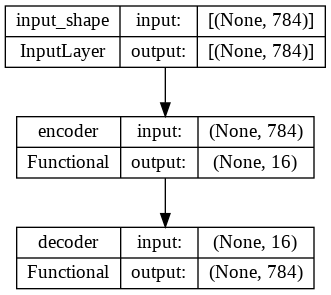

In [79]:
# 이렇게 구분된걸 묶어서 다시 하나의 모델로!  이게 구조화의 참맛
def vae():
  inputs = tf.keras.Input(shape=(784,), name='input_shape')
  z = E(inputs) # encoder
  outputs = D(z) # decoder
  return Model(inputs,outputs, name='vae_mlp'), Model(inputs, z, name='vae_E'), Model(z, outputs, name='vae_D')

#VAE 모델 정의
model = vae()
# model[0]: full model, model[1]: encoder, model[2]: decoder

#모델 네트워크 확인 
model[0].summary()
plot_model(model[0],to_file='vae_mlp.png',show_shapes=True)

오케이 이제 학습 갑시다

## 1.3. 학습

In [80]:
# 자 그럼 학습 
num_epochs = 100
batch_size = 20
learning_rate = 1e-3
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model[0].compile(optimizer= adam, loss='mse') # 회귀 문제 (근데 그 대상이 오리지날 이미지인) 니까 mse 를 써야죠?

# 학습 시작
hist = model[0].fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/100
3000/3000 [==============================] - 14s 4ms/step - loss: 0.0126
Epoch 2/100
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0126
Epoch 3/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0125
Epoch 4/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0125
Epoch 5/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0124
Epoch 6/100
3000/3000 [==============================] - 14s 5ms/step - loss: 0.0123
Epoch 7/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0123
Epoch 8/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0122
Epoch 9/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0122
Epoch 10/100
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0122
Epoch 11/100
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0121
Epoch 12/100
3000/3000 [==============================] - 12s 4

## 1.4. 결과 시각화

In [92]:
gen_images.shape

(1, 784)

In [94]:
# 한 번 그림으로 볼까요?
from google.colab.patches import cv2_imshow

image_idx = 0


while image_idx < 3:

  image = x_train[image_idx,:].reshape(28,28)
  print("ORIGINAL:")
  cv2_imshow((image - np.min(image)) / np.max(image - np.min(image)) * 255)


  gen_images = np.empty((28,0))
  for iter in range(10):
    gen_image = model[0].predict(x_train[image_idx].reshape(1,-1))
    gen_image = gen_image.reshape((28,28))
    gen_images =np.concatenate([gen_images, gen_image], axis=1)
  
  print("GENERATED{}:".format(image_idx))
  cv2_imshow((gen_images - np.min(gen_images)) / np.max(gen_images - np.min(gen_images)) * 255)

  print('*'*50)
  image_idx+=1

ORIGINAL:


1/1 [==============================] - 0s 20ms/step
GENERATED0:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 20ms/step
GENERATED1:


**************************************************
ORIGINAL:


1/1 [==============================] - 0s 24ms/step
GENERATED2:


**************************************************


다르다고는 하는데 막 티가 나진 않네요 그쵸? 억지로 다르게 해봅시다.

In [146]:
from google.colab.patches import cv2_imshow

image_idx = 0


while image_idx < 1:

  image = x_train[image_idx,:].reshape(28,28)
  print("ORIGINAL:")
  cv2_imshow((image - np.min(image)) / np.max(image - np.min(image)) * 255)


  z = model[1].predict(x_train[image_idx].reshape(1,-1))

  # z[0,i] 을 변화시켜봅시다
  step_change = 0.2 # 조금씩 변화
  for i in range(16):
    gen_images = np.empty((28,0))
    for iter in range(10):
      gen_image = model[2].predict(z.reshape(1,-1), verbose=0)
      gen_image = gen_image.reshape((28,28))
      gen_images =np.concatenate([gen_images, gen_image], axis=1)
      z[0,i] = z[0,i] + step_change

    print("GENERATED{}_{}:".format(image_idx,i))
    cv2_imshow((gen_images - np.min(gen_images)) / np.max(gen_images - np.min(gen_images)) * 255)
  
    
  print('*'*50)
  image_idx+=1
  

ORIGINAL:


1/1 [==============================] - 0s 44ms/step
GENERATED0_0:


GENERATED0_1:


GENERATED0_2:


GENERATED0_3:


GENERATED0_4:


GENERATED0_5:


GENERATED0_6:


GENERATED0_7:


GENERATED0_8:


GENERATED0_9:


GENERATED0_10:


GENERATED0_11:


GENERATED0_12:


GENERATED0_13:


GENERATED0_14:


GENERATED0_15:


**************************************************


# 2. GAN

드디어..!

근데 AE 나 VAE 랑 조금 많이 다르기 때문에 좀 잘 따라와보십쇼

수업할때도 (아마도) 들었겠지만 이건 결국 loss function 어떻게 잘 정의하고 그걸 번갈아가면서 - 각각 discriminator 와 generator를 각각 학습을 잘 시키는 부분이 매우매우 중요합니다.

그 부분을 찾아서 이해하면 정말 최고에요.


그리고 복잡한 gan 인데 우리 그냥 MNIST 쓰면 재미없죠?


## 2.1. 데이터 불러오기

In [157]:
# 별반 다를건 없지만 그래도 RGB 있는 CIFAR-10
from tensorflow.keras.datasets.cifar10 import load_data
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1,32*32*3))

In [158]:
x_train.shape

(50000, 3072)

In [159]:
np.max(x_train) # 0부터 1사이로 만들죠

1.0

## 2.2. 모델

이것도 vae 처럼 구조화 해야 사용하기 편합니다.

In [171]:
from numpy.core.numeric import outer
from tensorflow.keras.layers import Dense, Flatten, Lambda, LeakyReLU,BatchNormalization
from tensorflow.keras import Model
from tensorflow import shape,math
from tensorflow.keras.optimizers import Adam

In [179]:
# 먼저 generator
def generator():
  inputs = tf.keras.Input(shape=(3072,))
  x = Dense(256)(inputs)
  x = LeakyReLU(alpha=0.2)(x) # 그런게 있습니다. 오리지날 논문을 최대한 따라가려고 합니다.
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)
  out = Dense(3072, activation='sigmoid')(x)
  internal_model = Model(inputs=inputs, outputs=out, name="internal_generator")
  noise_inputs = tf.keras.Input(shape=(3072,))
  img_flat = internal_model(noise_inputs)
  return Model(noise_inputs,img_flat) 


In [180]:
# 다음은 discriminator
def discriminator():
  inputs = tf.keras.Input(shape=(3072,))
  x = Dense(512)(inputs)
  x = LeakyReLU(alpha=0.2)(x) 
  # 아니 여긴 왜 Batch Normalization 없음? 없는게 잘 되어서 그렇습니다
  # 왜요? 경험적으로 알게된거긴 하지만, Generator는 생성해내는거라 BN 같은게 있으면 인풋 데이터에따른
  # 차이를 좀 죽일수 있어서 좋죠.근데 여기는 그럴 필요가 없으니까 상대적으로 있을 필요가 적습니다.
  x = Dense(256)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)
  out = Dense(1, activation='sigmoid')(x) # 진짜 가짜 구분.
  internal_model = Model(inputs=inputs, outputs=out, name="internal_discriminator")
  img = tf.keras.Input(shape=(3072,))
  validity = internal_model(img)
  return Model(img, validity) 

## 2.3. 학습

아 이게 어려운데 잘 해봅시다.

어려운 부분은 저 두 녀석의 두 optimizer 를 각각 피팅을 해야한다는거에요. 그럴려면 단순하게 우리 여태 했던대로 `model.fit()` 이게 안된다는 겁니다. 모델이 두개니까...

그걸 잘 봅시다.

In [181]:
# 일단 두 모델을 선언합니다.
# Generator 와 Discriminator 를 각각 학습시켜야하기 때문에... 일단 generator 에 대한 학습파트 만들어놓구요.
generator = generator()
# generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator = discriminator()
discriminator.compile(loss = 'binary_crossentropy',optimizer = Adam(0.0002, 0.5), metrics   = ['accuracy'])

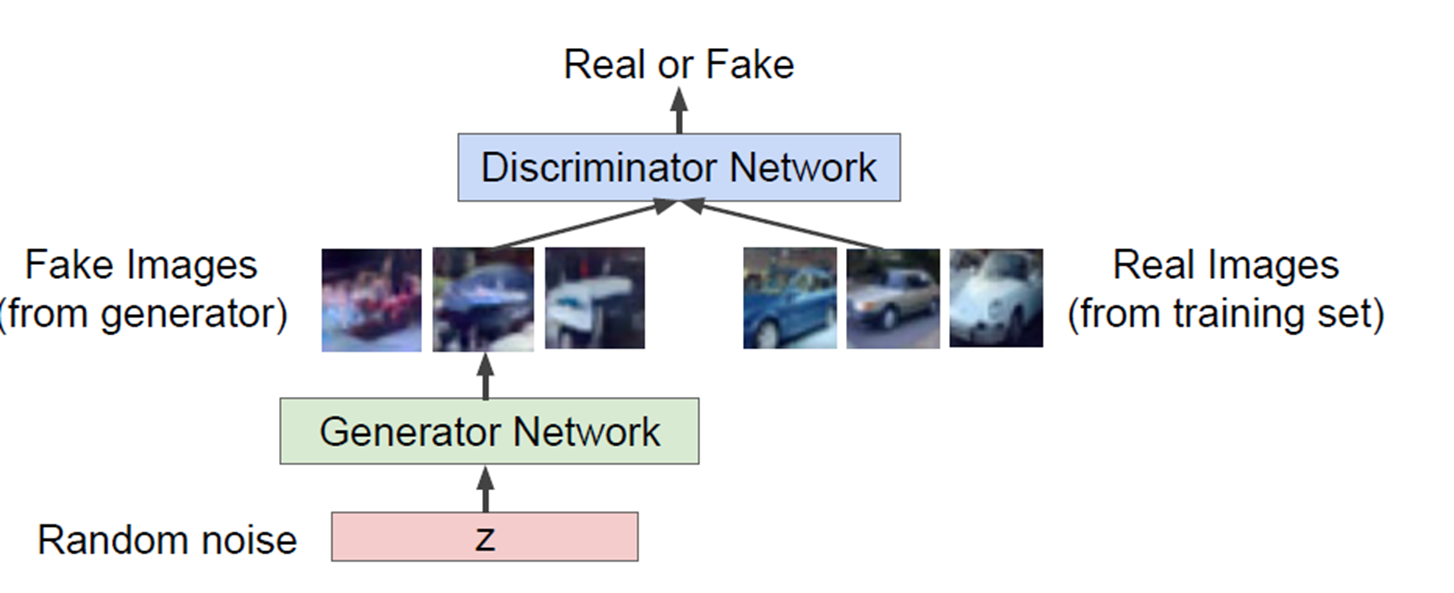

먼저 위 그림에서 정보의 흐름을 기억하면 좀 편한데요,

noise --> generator --> discriminator 죠?

In [182]:
# 1. noise
z = tf.keras.layers.Input(shape=(3072,), name="noise")

# 2. generator
gen_img = generator(z)

# 3. discriminator 
discriminator.trainable = False 
valid = discriminator(gen_img)

  # 이게 discriminator를 학습을 꺼두는 이유는 
  # 두 모델을 묶은 아래 model_gan 에서 학습시 discriminator 도 학습되는 방식으로 2중으로 학습되기 때문에.
  # model_gan=generator+discriminator 을 학습? 
    # --> generator 학습하는 것 (discriminator는 꺼뒀다)
  # discriminator 를 학습?
    # --> discriminator 학습하는 것 (그것이... 학습이니까)


# 합+체
gan_model = Model(z, valid)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 3072)]            0         
                                                                 
 model_11 (Functional)       (None, 3072)              4599552   
                                                                 
 model_12 (Functional)       (None, 1)                 1968897   
                                                                 
Total params: 6,568,449
Trainable params: 4,595,968
Non-trainable params: 1,972,481
_________________________________________________________________


In [185]:
batch_size = 128
epochs = int(1e4)

valid = np.ones((batch_size, 1)) # 1: 진짜 데이터
fake = np.zeros((batch_size, 1)) # 0: 가짜 데이터
history = []
for epoch in range(epochs):
  # 직접 배치 사이즈만큼 샘플링 하구요
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  ##############################
  # Part 1. Discriminator 학습 #
  ##############################

  # 1. noise 
  noise = np.random.normal(0, 1, (batch_size, 3072))
  
  # 2. generator - 이미지 만들기
  gen_imgs = generator.predict(noise)

  # 3. discriminator
    # 진짜와 가짜 각각에 대해 학습.
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 그래서 얼마나 잘하는지 loss 계산

  ##############################
  # Part 2. Generator 학습     #
  ##############################

  # 1. noise 
  noise = np.random.normal(0, 1, (batch_size, 3072))
  
  # 2. generator - 아까도 말했지만 gan_model 로부터 학습할겁니다.
    # 이 gan_model 은 discriminator 가 trainable 하지 않게 되어있어서 generator만 학습합니다.
  g_loss = gan_model.train_on_batch(noise, valid)

  # 3. discriminator 는 학습안하니까 필요없죠

  # 그리고 저장합시다.
  history.append({"D":d_loss[0],"G":g_loss})

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4/4 [==============================] - 0s 20ms/step
7500 [D loss: 0.695092, acc.: 49.22%] [G loss: 0.696892]
4/4 [==============================] - 0s 23ms/step
7501 [D loss: 0.694681, acc.: 47.66%] [G loss: 0.697610]
4/4 [==============================] - 0s 21ms/step
7502 [D loss: 0.694435, acc.: 36.72%] [G loss: 0.697665]
4/4 [==============================] - 0s 22ms/step
7503 [D loss: 0.694749, acc.: 37.89%] [G loss: 0.697489]
4/4 [==============================] - 0s 20ms/step
7504 [D loss: 0.694294, acc.: 45.70%] [G loss: 0.698354]
4/4 [==============================] - 0s 23ms/step
7505 [D loss: 0.694483, acc.: 46.09%] [G loss: 0.698087]
4/4 [==============================] - 0s 19ms/step
7506 [D loss: 0.696364, acc.: 46.09%] [G loss: 0.698836]
4/4 [==============================] - 0s 26ms/step
7507 [D loss: 0.693862, acc.: 19.53%] [G loss: 0.700368]
4/4 [==============================] - 0s 31ms/step
7508 [D loss: 0.694898, acc.: 13.28%] [G

## 2.4. 결과 시각화

GENERATED:


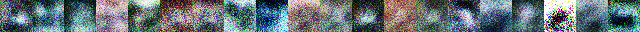

**************************************************


In [190]:
# 한 번 그림으로 볼까요?
from google.colab.patches import cv2_imshow

gen_images = np.empty((32,0,3))
for iter in range(20):
  noise = np.random.normal(0, 1, (1, 3072))
  gen_image = generator.predict(noise,verbose=0)
  gen_image = gen_image.reshape((32,32,3))
  gen_images =np.concatenate([gen_images, gen_image], axis=1)

print("GENERATED:")
cv2_imshow((gen_images - np.min(gen_images)) / np.max(gen_images - np.min(gen_images)) * 255)

print('*'*50)


왜 잘 안나왔을까요?

1. 당연히 training 이 부족한것도 있죠

2. 그러나 칼라 이미지기 때문에, CNN 을 쓰는 GAN 모델이 더 유의미할 수 있겠습니다.

3. CNN 을 쓰는 GAN (Deep convolution GAN, DCGAN) 을 쓰더라도 학습에 시간이 많이 걸리기 때문에.. 오래오래 해야겠죠?

  - 어떻게 만드나요? 

    당연하게도, Conv2DTranspose를 써서 만드시면됩니다.

